In [2]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid


In [3]:
#change to your username and you kaggle key
! export KAGGLE_USERNAME="samerkhair8" && export KAGGLE_KEY="cd1614de2158af1dc08d719472edc6f8" && kaggle datasets download --force --unzip lexset/synthetic-asl-alphabet
! ls

100%|██████████████████████████████████████▉| 6.57G/6.58G [00:59<00:00, 141MB/s]
100%|███████████████████████████████████████| 6.58G/6.58G [00:59<00:00, 119MB/s]
/bin/bash: line 1:  ls: command not found


In [5]:
import os
import random
import shutil

def copy_and_delete_random_pictures(source_dir, destination_dir, num_pictures=100):
    # Get the list of all files in the source directory
    file_list = os.listdir(source_dir)

    # Select random files from the list
    random_files = random.sample(file_list, num_pictures)

    # Copy the selected files to the destination directory and delete them from the source directory
    for file_name in random_files:
        source_path = os.path.join(source_dir, file_name)
        destination_path = os.path.join(destination_dir, file_name)
        shutil.copy2(source_path, destination_path)
        os.remove(source_path)

In [6]:
import os
import shutil

# Define the source and destination directories
source_dir = '/kaggle/working/Train_Alphabet'
destination_dir = '/kaggle/working/Test_Alphabet'

# Get a list of all alphabets
alphabets = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Copy images from source to destination directory for each alphabet
for alphabet in alphabets:
    # Construct the source and destination paths for uppercase and lowercase alphabets
    source_upper = os.path.join(source_dir,f"{alphabet}/")
    dest_upper = os.path.join(destination_dir,f"{alphabet}/")
    copy_and_delete_random_pictures(source_upper, dest_upper, num_pictures=100)
    # Copy the images
    #shutil.copyfile(source_upper, dest_lower)
    print(f"Images copied for alphabet {alphabet}")

#copy_blank
source_upper = os.path.join(source_dir,"Blank/")
dest_upper = os.path.join(destination_dir,"Blank/")
copy_and_delete_random_pictures(source_upper, dest_upper, num_pictures=100)
print(f"Images copied for Blank")

Images copied for alphabet A
Images copied for alphabet B
Images copied for alphabet C
Images copied for alphabet D
Images copied for alphabet E
Images copied for alphabet F
Images copied for alphabet G
Images copied for alphabet H
Images copied for alphabet I
Images copied for alphabet J
Images copied for alphabet K
Images copied for alphabet L
Images copied for alphabet M
Images copied for alphabet N
Images copied for alphabet O
Images copied for alphabet P
Images copied for alphabet Q
Images copied for alphabet R
Images copied for alphabet S
Images copied for alphabet T
Images copied for alphabet U
Images copied for alphabet V
Images copied for alphabet W
Images copied for alphabet X
Images copied for alphabet Y
Images copied for alphabet Z
Images copied for Blank


In [7]:
#creating the dataloaders 
import os

# Define transforms for the training data and testing data
train_path='/kaggle/working/Train_Alphabet'
valid_path='/kaggle/working/Test_Alphabet'

#train_path = os.path.join(train_path, "asl_dataset")
#valid_path = os.path.join(valid_path, "asl_test")

train_transforms = transforms.Compose([transforms.Resize((256,256)),
                                       transforms.RandomRotation(20),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])
                                   # transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   #                         (0.2023, 0.1994, 0.2010))])


test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor()])
                                    #   transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    #                        (0.2023, 0.1994, 0.2010))])

## 3.2. load images to data loaders

Now it is time to create data loaders to feed our model with data during the training phase.  
We will use <a href="https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder">ImageFolder</a> from torchvision to load our data.    
We also print the used processor to make sure we are using the GPU for faster training, In our case, it is Tesla k80.  
We will also print "class_to_idx" to show how our classess are mapped to different integers or indices.

In [8]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)
#batch 512
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

#print used Device
print(f"Device used: {torch.cuda.get_device_name(0)}")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")
print(f"class to index mapping: {test_data.class_to_idx}")


Device used: Tesla T4
class to index mapping: {'A': 0, 'B': 1, 'Blank': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
class to index mapping: {'A': 0, 'B': 1, 'Blank': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [9]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import GELU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam
from torch import nn


In [9]:
! pip install  --upgrade kornia

In [11]:
#Section 5
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential

# define a sequence of augmentations
aug_list = AugmentationSequential(
  K.ColorJitter(0.2, 0.2, 0.2, 0.2),
  K.RandomPerspective(0.2),
  K.RandomErasing(p=0.5, scale=(0.02,0.2),ratio = (0.3,3.3)),
)


## 6.2. Start the training loop
Set back and watch your model learn.

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

In [108]:
#Section 2
import time

num_groups = 4

class SVHN_NN(nn.Module):
    """CNN for the SVHN Datset"""
    def __init__(self):
        """CNN Builder."""
        super(SVHN_NN, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # `paading=1` is the same as `padding='same'` for 3x3 kernels size
            nn.GroupNorm(num_groups, 32, eps=1e-05, affine=True, device=None, dtype=None),
            #nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups*num_groups, 128, eps=1e-05, affine=True, device=None, dtype=None),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(8*num_groups, 256, eps=1e-05, affine=True, device=None, dtype=None),
            #nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=7, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=15, padding=1),
            nn.GroupNorm(8*num_groups, 256, eps=1e-05, affine=True, device=None, dtype=None),
            )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(256,1024),
            nn.Dropout(p=0.1),
            nn.PReLU(),
            nn.Linear(1024,256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(256,128),
            nn.Dropout(p=0.1),
            nn.Linear(128,27)
            )
        

    def forward(self, x):
            """Perform forward."""

            # conv layers
            x = self.conv_layer(x)

            # flatten
            x = x.view(x.size(0), -1)

            # fc layer
            x = self.fc_layer(x)
            return x



In [13]:
batch_size = 128
learning_rate = 1e-4
epochs = 15

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = SVHN_NN().to(device) # no need for parameters as we alredy defined them in the class

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode, turn of DropOut, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([27,27], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix


# 7. Test The Model After Training

In [16]:
test_error = [] #loss of test
loss_error = [] #loss of train
accuracy_final = [] # accuracy of test
accuracy_train_final = [] # accuracy of train

# training loop
for epoch in range(1, epochs + 1):
    model.train() # put in training mode, turn on DropOut, BatchNorm uses batch's statistics
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # augmentation with `kornia` happens here inputs = aug_list(inputs)
        #inputs = aug_list(inputs)
        # forward + backward + optimize
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        # print statistics
        running_loss += loss.data.item()
        
    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)
    loss_error.append(running_loss)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    accuracy_train_final.append(train_accuracy)

    test_accuracy, _ = calculate_accuracy(model, testloader, device)
    accuracy_final.append(test_accuracy)

    # Calculate test loss
    model.eval() # put in evaluation mode
    test_loss = 0.0
    with torch.no_grad():
      for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).data.item()
    test_loss /= len(testloader)
    test_error.append(test_loss)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    # with f-strings
    # log = f"Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Testaccuracy: {test_accuracy:.3f}% |"
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    # with f-strings
    # log += f"Epoch Time: {epoch_time:.2f} secs"
    print(log)

    # save model
print('==> Finished Training ...')

Epoch: 1 | Loss: 3.2955 | Training accuracy: 4.094% | Test accuracy: 4.092% | Epoch Time: 1315.73 secs
Epoch: 2 | Loss: 3.2919 | Training accuracy: 4.588% | Test accuracy: 4.712% | Epoch Time: 1329.26 secs
Epoch: 3 | Loss: 2.6830 | Training accuracy: 62.097% | Test accuracy: 63.860% | Epoch Time: 1312.56 secs
Epoch: 4 | Loss: 0.7876 | Training accuracy: 86.227% | Test accuracy: 86.316% | Epoch Time: 1313.44 secs
Epoch: 5 | Loss: 0.4155 | Training accuracy: 91.573% | Test accuracy: 90.927% | Epoch Time: 1303.57 secs
Epoch: 6 | Loss: 0.2826 | Training accuracy: 93.628% | Test accuracy: 92.554% | Epoch Time: 1306.21 secs
Epoch: 7 | Loss: 0.2052 | Training accuracy: 95.726% | Test accuracy: 95.019% | Epoch Time: 1304.98 secs
Epoch: 8 | Loss: 0.1551 | Training accuracy: 96.454% | Test accuracy: 95.891% | Epoch Time: 1302.18 secs
Epoch: 9 | Loss: 0.1234 | Training accuracy: 96.890% | Test accuracy: 95.942% | Epoch Time: 1302.42 secs
Epoch: 10 | Loss: 0.1048 | Training accuracy: 97.823% | Tes

In [91]:
!pip install torchsummary

In [110]:
from torchsummary import summary
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SVHN_NN().to(device)
#model = SVHN_NN()
#first_layer = model.conv_layer[0]
#input_size = first_layer.in_channels, first_layer.input_size[1],first_layer.input_size[2]
#print("Input size :", input_size)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         GroupNorm-2         [-1, 32, 256, 256]              64
             PReLU-3         [-1, 32, 256, 256]               1
            Conv2d-4         [-1, 64, 256, 256]          18,496
             PReLU-5         [-1, 64, 256, 256]               1
         MaxPool2d-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
         GroupNorm-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
            PReLU-11        [-1, 128, 128, 128]               1
        MaxPool2d-12          [-1, 128, 64, 64]               0
        Dropout2d-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

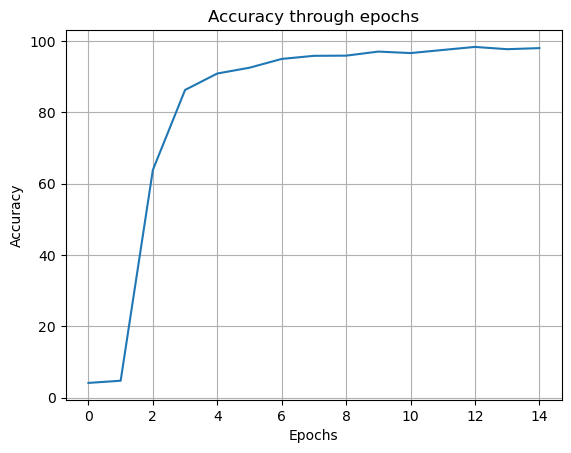

In [20]:
# 👇️ import pyplot and alias it as plt
import matplotlib.pyplot as plt

# Create the plot
epochs = range(15)
plt.plot(epochs, accuracy_final)
plt.title('Accuracy through epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

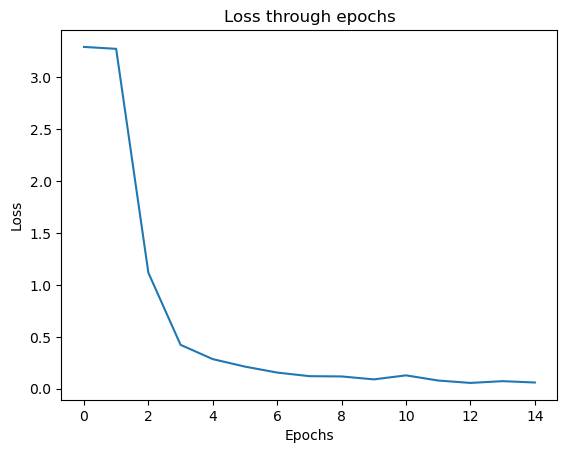

In [22]:
# plot the loss curves
plt.plot(epochs,test_error)
plt.title('Loss through epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

odict_keys(['conv_layer.0.weight', 'conv_layer.0.bias', 'conv_layer.1.weight', 'conv_layer.1.bias', 'conv_layer.2.weight', 'conv_layer.3.weight', 'conv_layer.3.bias', 'conv_layer.4.weight', 'conv_layer.6.weight', 'conv_layer.6.bias', 'conv_layer.7.weight', 'conv_layer.7.bias', 'conv_layer.9.weight', 'conv_layer.9.bias', 'conv_layer.10.weight', 'conv_layer.13.weight', 'conv_layer.13.bias', 'conv_layer.14.weight', 'conv_layer.14.bias', 'conv_layer.15.weight', 'conv_layer.16.weight', 'conv_layer.16.bias', 'conv_layer.19.weight', 'conv_layer.19.bias', 'conv_layer.20.weight', 'conv_layer.23.weight', 'conv_layer.23.bias', 'conv_layer.24.weight', 'conv_layer.24.bias', 'fc_layer.1.weight', 'fc_layer.1.bias', 'fc_layer.2.weight', 'fc_layer.3.weight', 'fc_layer.3.bias', 'fc_layer.6.weight', 'fc_layer.6.bias', 'fc_layer.8.weight', 'fc_layer.9.weight', 'fc_layer.9.bias', 'fc_layer.12.weight', 'fc_layer.12.bias', 'fc_layer.14.weight', 'fc_layer.14.bias'])
test accuracy: 99.044%


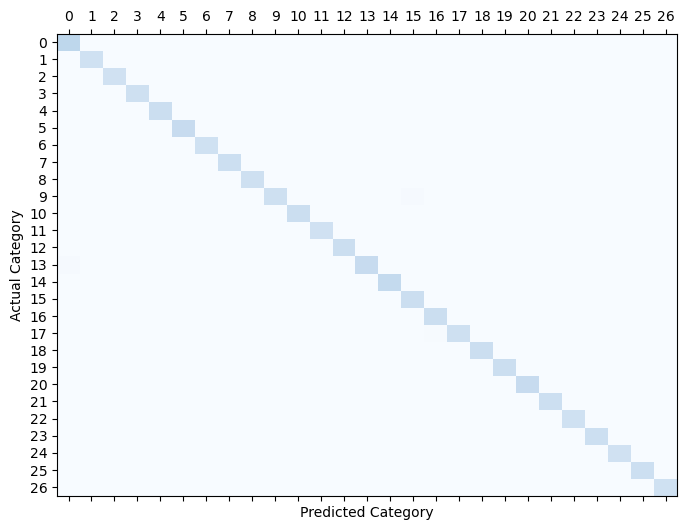

In [42]:
# load model, calculate accuracy and confusion matrix
model = SVHN_NN().to(device)
state = torch.load('/kaggle/input/moot-moot-moot/classifier.pth', map_location=device)
#state = torch.load('/kaggle/working/classifier.pth', map_location=device)
print(state.keys())  # Print the keys to identify the correct key

# Load the model's state dictionary
model.load_state_dict(state)  # Replace 'net' with the correct key
#model.load_state_dict(state['net'])
# note: `map_location` is necessary if you trained on the GPU and want to run inference on the CPU
test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))
# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(27), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(27), classes)
plt.show()


In [29]:
classes = {
    0: "A",
    1: "B",
    2: "Blank",
    3: "C",
    4: "D",
    5: "E",
    6: "F",
    7: "G",
    8: "H",
    9: "I",
    10: "J",
    11: "K",
    12: "L",
    13: "M",
    14: "N",
    15: "O",
    16: "P",
    17: "Q",
    18: "R",
    19: "S",
    20: "T",
    21: "U",
    22: "V",
    23: "W",
    24: "X",
    25: "Y",
    26: "Z",

}

In [31]:
torch.save(model.state_dict(), 'classifier.pth')